# Causal programming

## Load namespace

In [1]:
(require '[acausal.core :as a
           :refer [defmodel model q query p data identify]]
         '[clojure.pprint :refer [pprint]]
         :reload-all)

## Model

Assume that the effect of smoking ($X$) on cancer ($Y$) is mediated by tar ($Z$). However, there may be a latent factor that affects both smoking and cancer. $\epsilon_X, \epsilon_Y, \epsilon_Z$ are 'background' variables, representing factors not directly accounted for in this model:

$$ X = f_X(\epsilon_X) $$
$$ Z = f_Z(x, \epsilon_Z) $$
$$ Y = f_Y(z, \epsilon_Y) $$
$$ \epsilon_X \not\bot\!\!\bot \epsilon_Y$$

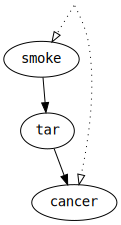

In [2]:
(defmodel pearl1995
    "Fig. 3 from Causal diagrams for empirical research (Pearl 1995)."
    {:smoke []
     :tar [:smoke]
     :cancer [:tar]}
    #{:smoke :cancer})

## Query

$P(\text{cancer} \mid do(\text{smoke}))$ represents the *causal effect* of smoking on cancer. Note that this may be different than the conditional probability of cancer, given smoking, i.e. $P(\text{cancer} \mid \text{smoke})$ due to the latent confounding.

In [3]:
(query [:cancer] :do [:smoke])

#acausal.core.Query{:effect #{:cancer}, :do #{:smoke}}

## Identify

Calculate the causal effect $P(\text{cancer} \mid do(\text{smoke}))$ as a function of $P(\text{smoking}, \text{tar}, \text{cancer})$.

In [4]:
(pprint
    (a/compile-formula
    (a/id
    #{:cancer}
    #{:smoke}
    {:p #{:cancer :smoke :tar}}
    pearl1995)))

{:sum
 {:prod
  #{{:numer {:sum {:p #{:tar :cancer :smoke}}, :sub #{:cancer}},
     :denom
     {:sub #{:tar},
      :sum {:sum {:p #{:tar :cancer :smoke}}, :sub #{:cancer}}}}
    {:sum
     {:prod
      #{{:numer {:p #{:tar :cancer :smoke}},
         :denom {:sub #{:cancer}, :sum {:p #{:tar :cancer :smoke}}}}
        {:sub #{:tar :cancer}, :sum {:p #{:tar :cancer :smoke}}}}},
     :sub #{:smoke}}}},
 :sub #{:tar}}


In [5]:
(identify
    pearl1995
    (query [:cancer] :do [:smoke]))

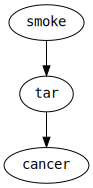

In [6]:
(defmodel no-confounding
    {:smoke []
     :tar [:smoke]
     :cancer [:tar]})

In [7]:
(identify
    no-confounding
    (q [:cancer] :do [:smoke]))

Note that this is equivalent to $P(\text{cancer} \mid \text{smoke})$

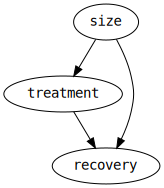

In [8]:
(defmodel charig1986
    {:treatment [:size]
     :size []
     :recovery [:treatment :size]})

In [9]:
(identify
    charig1986
    (q [:recovery] :do [:treatment]))

Note that this is equivalent to $\sum_\text{size} P(\text{recovery} \mid \text{size}, \text{treatment}) P(\text{size})$

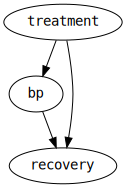

In [10]:
(defmodel charig-hypothetical
    {:treatment []
     :bp [:treatment]
     :recovery [:treatment :bp]})

In [11]:
(identify
    charig-hypothetical
    (q [:recovery] :do [:treatment]))

Note that this is equivalent to $\sum_\text{bp} P(\text{recovery} \mid \text{bp}, \text{treatment}) P(\text{bp} \mid \text{treatment})$

Which simplifies to:

$P(\text{recovery} \mid \text{treatment})$

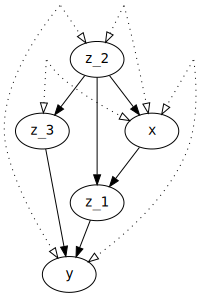

In [12]:
(defmodel shpitser2008
    "Figure 2g from (Shpitser + Pearl 2008)"
    {:x [:z_2]
     :z_1 [:x :z_2]
     :z_2 []
     :z_3 [:z_2]
     :y [:z_1 :z_3]}
    #{:x :z_2}
    #{:x :z_3}
    #{:x :y}
    #{:y :z_2})

In [13]:
(identify
    shpitser2008
    (q [:y] :do [:x]))

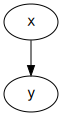

In [14]:
(defmodel simple
    {:y [:x]
     :x []})

In [15]:
(identify
    simple
    (q [:y] :do [:x]))

In [16]:
(identify
    simple
    (q [:x] :do [:y]))

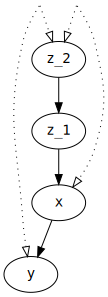

In [17]:
(defmodel napkin
    "Napkin model"
    {:z_1 [:z_2]
     :x [:z_1]
     :y [:x]
     :z_2 []}
    #{:x :z_2}
    #{:z_2 :y})

In [18]:
(pprint
    (a/id
    #{:y}
    #{:x}
    {:p #{:x :y :z_1 :z_2}}
    napkin))

{:p #{:y},
 :given #{:x},
 :where
 {:sub #{:z_2},
  :sum
  {:prod
   #{{:p #{:y}, :given #{:z_2 :z_1 :x}, :where {:p #{:y :z_2 :z_1 :x}}}
     {:p #{:z_2}, :where {:p #{:y :z_2 :z_1 :x}}}
     {:p #{:x}, :given #{:z_2 :z_1}, :where {:p #{:y :z_2 :z_1 :x}}}}}}}


In [19]:
(identify
    napkin
    (q [:y] :do [:x]))

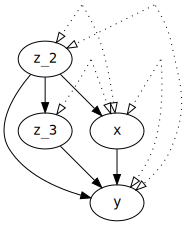

In [20]:
(defmodel non-identifiable
    {:x [:z_2]
     :z_2 []
     :z_3 [:z_2]
     :y [:x :z_2 :z_3]}
    #{:x :z_2}
    #{:x :z_3}
    #{:x :y}
    #{:y :z_2})

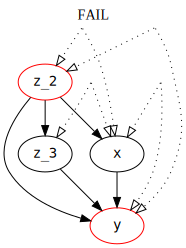

In [21]:
(identify
    non-identifiable
    (q [:y] :do [:x]))

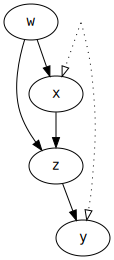

In [42]:
(defmodel tikka
    {:w []
     :x [:w]
     :z [:x :w]
     :y [:z]}
    #{:x :y})

In [43]:
(identify
    tikka
    (q [:y] :do [:x]))

In [45]:
(pprint
    (a/id
    #{:y}
    #{:x}
    {:p #{:w :x :y :z}}
    tikka))

{:sub #{:w :z},
 :sum
 {:prod
  #{{:sub #{:y :z :x}, :sum {:p #{:y :w :z :x}}}
    {:sub #{:x},
     :sum
     {:prod
      #{{:p #{:y}, :given #{:w :z :x}, :where {:p #{:y :w :z :x}}}
        {:p #{:x}, :given #{:w}, :where {:p #{:y :w :z :x}}}}}}
    {:p #{:z},
     :given #{:w :x},
     :where {:sub #{:y}, :sum {:p #{:y :w :z :x}}}}}}}
